In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs
from scipy.signal import welch
import os
import h5py
from utils.beh_functions import session_dirs
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.preprocessing as spre
from spikeinterface.core.sorting_tools import random_spikes_selection
import pandas as pd
from utils.beh_functions import parseSessionID, get_unit_tbl
%matplotlib inline

In [3]:
session = 'behavior_754897_2025-03-13_11-20-42'
session_dir = session_dirs(session)

In [4]:
compressed_folder = session_dir['session_dir_raw']
stream_name = 'ProbeA'
recording_zarr = [os.path.join(compressed_folder, f) for f in os.listdir(compressed_folder) if stream_name in f and 'LFP' not in f][0]
recording = si.read_zarr(recording_zarr)

In [5]:
data_type = 'curated'
target  = 'soma'
opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_session_{target}.csv'), index_col=0)
laser_onset_samples = opto_df['laser_onset_samples'].values
session_period_ind = np.argmax(np.diff(laser_onset_samples))
session_start_sample = laser_onset_samples[session_period_ind] + 30000*10 # added 10 second to remove the whole laser train and artifact
session_end_sample = laser_onset_samples[session_period_ind + 1]
session_length = session_end_sample - session_start_sample
laser_onset_times = opto_df['time'].values
session_start_time = laser_onset_times[session_period_ind]
session_end_time = laser_onset_times[session_period_ind + 1]
print(str(session_length/(30000*60)) + ' min')

79.23534 min


In [31]:
recording_ps = spre.phase_shift(recording, margin_ms=100.0)
recording_hp = spre.highpass_filter(recording_ps, freq_min=300, filter_order=5)
recording_hp = spre.common_reference(recording_hp, reference='global', operator='median')
recording_bp = spre.bandpass_filter(recording_ps, freq_min=300, freq_max=6000)
recording_bp = spre.common_reference(recording_bp, reference='global', operator='median')
recording_hp1 = spre.highpass_filter(recording_ps, freq_min=300, filter_order=1)
recoridng_hp1 = spre.common_reference(recording_hp1, reference='global', operator='median')
recording_bp1 = spre.bandpass_filter(recording_ps, freq_min=300, freq_max=6000, filter_order=2)
recording_bp1 = spre.common_reference(recording_bp1, reference='global', operator='median')

In [6]:
num_bins = 5
time_frames = np.linspace(session_start_sample, session_end_sample, num_bins + 1)
chunk_size_second = 5 # seconds

0
1
2
3
4


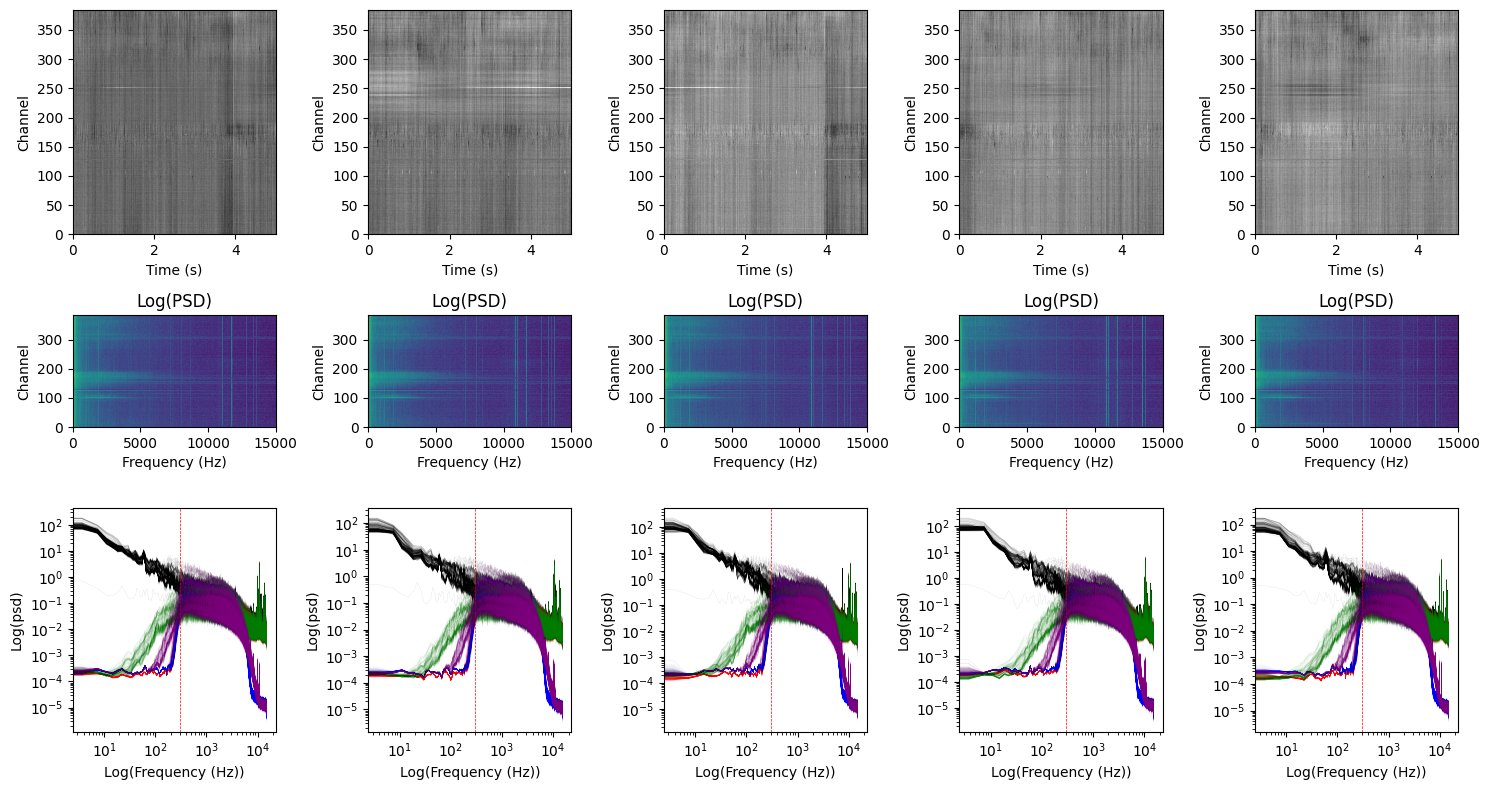

In [28]:
fig = plt.figure(figsize=(15, 8))
gs_psd = gs(nrows=3, ncols=num_bins, height_ratios=[2, 1, 2], width_ratios=[1] * num_bins)

for bin_ind in range(num_bins):
    print(bin_ind)
    start_frame = time_frames[bin_ind]
    end_frame = start_frame + chunk_size_second*30000
    data = recording.get_traces(start_frame=start_frame,
                        end_frame=end_frame,
                        return_scaled=True)
    # time = np.linspace(start_time, end_time, data.shape[0])
    ax = fig.add_subplot(gs_psd[0, bin_ind])

    ax.imshow(
        data.T,
        extent=[0, chunk_size_second, 0, data.shape[1]],
        aspect='auto',
        origin='lower',
        cmap='gray',
        interpolation='none'
    )

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channel')

    # data = data.reshape(-1, 1)  # Ensure data is in the correct shape for plotting
    frequencys, psd = welch(data.T, fs=recording.get_sampling_frequency(), nperseg=8096)

    ax = fig.add_subplot(gs_psd[1, bin_ind])
    ax.imshow(X=np.log(psd), 
              extent=[frequencys[0], frequencys[-1], 0, data.shape[1]],
              aspect='auto',
              origin='lower',
              cmap='viridis',
              interpolation='none'
    )
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Channel')
    ax.set_title('Log(PSD)')

    ax = fig.add_subplot(gs_psd[2, bin_ind])
    ax.plot(frequencys, psd.T, 
              color='black', 
              alpha=0.3, 
              linewidth=0.1
    )
    ax.set_xlabel('Log(Frequency (Hz))')
    ax.set_ylabel('Log(psd)')

    data_hp = recording_hp.get_traces(start_frame=start_frame,
                        end_frame=end_frame,
                        return_scaled=True)
    frequencys_hp, psd_hp = welch(data_hp.T, fs=recording.get_sampling_frequency(), nperseg=8096)
    ax.loglog(frequencys_hp, psd_hp.T,
              color='red', 
              alpha=0.2, 
              linewidth=0.05)

    data_bp = recording_bp.get_traces(start_frame=start_frame,
                        end_frame=end_frame,
                        return_scaled=True)
    frequencys_bp, psd_bp = welch(data_bp.T, fs=recording.get_sampling_frequency(), nperseg=8096)

    ax.loglog(frequencys_bp, psd_bp.T,
                color='blue', 
                alpha=0.2, 
                linewidth=0.05)

    data_hp1 = recoridng_hp1.get_traces(start_frame=start_frame,
                        end_frame=end_frame,
                        return_scaled=True)
    frequencys_hp1, psd_hp1 = welch(data_hp1.T, fs=recording.get_sampling_frequency(), nperseg=8096)
    ax.loglog(frequencys_hp1, psd_hp1.T,
                color='green',  
                alpha=0.2, 
                linewidth=0.05)
    ax.axvline(300, color='r', linestyle='--', linewidth=0.5)
    data_bp1 = recording_bp1.get_traces(start_frame=start_frame,
                        end_frame=end_frame,
                        return_scaled=True)
    frequencys_bp1, psd_bp1 = welch(data_bp1.T, fs=recording.get_sampling_frequency(), nperseg=8096)
    ax.loglog(frequencys_bp1, psd_bp1.T,
                color='purple', 
                alpha=0.2, 
                linewidth=0.05)

plt.tight_layout()
plt.show()
# data = recording.get_traces(start_frame=30000*500, end_frame=30000*1000, channel_ids=['CH1'], return_scaled=True)

In [9]:
def load_and_preprocess_recording(session_folder, stream_name):
    si.set_global_job_kwargs(n_jobs=5, progress_bar=True)
    ephys_path = os.path.dirname(session_folder)
    compressed_folder = os.path.join(ephys_path, 'ecephys_compressed')
    recording_zarr = [os.path.join(compressed_folder, f) for f in os.listdir(compressed_folder) if stream_name in f and 'LFP' not in f][0]
    
    recording = si.read_zarr(recording_zarr)
    # preprocess
    recording_processed = spre.phase_shift(recording)
    recording_processed = spre.highpass_filter(recording_processed)
    # recording_processed = spre.bandpass_filter(recording_processed, freq_min=300, freq_max=6000)    
    recording_processed = spre.common_reference(recording_processed)
    return recording_processed

In [47]:
sorting = si.load(session_dir[f'curated_dir_{data_type}'], load_extensions=False)
spike_vector_session = sorting.to_spike_vector()
unit_ids = sorting.unit_ids
num_units = len(sorting.unit_ids)
print(f"Total {len(sorting.unit_ids)} units")

Total 269 units


In [74]:
sorting_analyzer.sparsity

NameError: name 'sorting_analyzer' is not defined

In [48]:
sorting_session = si.NumpySorting(
    spike_vector_session, 
    unit_ids=unit_ids, 
    sampling_frequency=sorting.sampling_frequency
)

random_spike_indices = random_spikes_selection(sorting_session, method="uniform",
                                            max_spikes_per_unit=500)
sorting_session = si.NumpySorting(
    spike_vector_session[random_spike_indices], 
    unit_ids=unit_ids, 
    sampling_frequency=sorting.sampling_frequency)


In [13]:
# raw
recording_wf = spre.common_reference(recording, reference='global', operator='median')

recording_processed = spre.phase_shift(recording)
# hp

recording_wf_hp = spre.highpass_filter(recording_processed, filter_order=5)   
recording_wf_hp = spre.common_reference(recording_wf_hp)
# bp

recording_wf_bp = spre.bandpass_filter(recording_processed, freq_min=300, freq_max=6000)  
recording_wf_bp = spre.common_reference(recording_wf_bp)  


In [42]:
# orders = range(5)
# for order_ind, order in enumerate(orders):
#     recording_wf_bp = spre.bandpass_filter(recording_processed, freq_min=300, freq_max=6000, filter_order=order+1)
#     recording_wf_bp = spre.common_reference(recording_wf_bp)
#     recording_wf_bp = recording_wf_bp.select_channels(good_channel_ids)
#     # %%
#     # create analyzer
#     analyzer_wf = si.create_sorting_analyzer(
#         # sorting_all.select_units(ROI_unit_ids),
#         sorting_session,
#         recording_wf_bp,
#         sparsity=sparsity_wf
#     )

#     # %%
#     min_spikes_per_unit = 100
#     keep_unit_ids = []
#     count_spikes = sorting_session.count_num_spikes_per_unit()
#     for unit_id, count in count_spikes.items():
#         if count >= min_spikes_per_unit:
#             keep_unit_ids.append(unit_id)

#     analyzer_wf = analyzer_wf.select_units(keep_unit_ids)
#         # %%
#     si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)
#     _ = analyzer_wf.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
#     _ = analyzer_wf.compute(["waveforms", "templates"])
#     analyzer_wf.save_as(format = 'zarr', folder = os.path.join(session_dir[f'ephys_dir_{data_type}'], f'bp_{order+1}.zarr'))


compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

In [69]:
# raw
recording_wf = spre.common_reference(recording, reference='global', operator='median')

recording_processed = spre.phase_shift(recording)

recording_raw_fake = spre.bandpass_filter(recording_processed, freq_min=5, freq_max=8000)
recording_raw_fake = spre.common_reference(recording_raw_fake)

In [70]:

we = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)
good_channel_ids = recording_wf.channel_ids[
    np.isin(recording_wf.channel_ids, we.channel_ids)
]


In [79]:
we_selected = we.select_units(unit_ids[:20])

In [81]:
we_selected.sparsity

ChannelSparsity - units: 20 - channels: 384 - density, P(x=1): 0.06

In [77]:
we.sparsity.to_dict().keys()

dict_keys(['unit_id_to_channel_ids', 'channel_ids', 'unit_ids'])

In [71]:

recording_wf = recording_wf.select_channels(good_channel_ids)
# recording_wf_hp = recording_wf_hp.select_channels(good_channel_ids)
# recording_wf_bp = recording_wf_bp.select_channels(good_channel_ids)
# recording_bp1 = recording_bp1.select_channels(good_channel_ids)
# recording_hp1 = recoridng_hp1.select_channels(good_channel_ids)
recording_raw_fake = recording_raw_fake.select_channels(good_channel_ids)
# sparsity
sparsity_wf = we.sparsity


In [56]:
# %%
# create analyzer
analyzer_wf = si.create_sorting_analyzer(
    # sorting_all.select_units(ROI_unit_ids),
    sorting_session,
    recording_raw_fake,
    sparsity=sparsity_wf
)

# %%
min_spikes_per_unit = 100
keep_unit_ids = []
count_spikes = sorting_session.count_num_spikes_per_unit()
for unit_id, count in count_spikes.items():
    if count >= min_spikes_per_unit:
        keep_unit_ids.append(unit_id)

analyzer_wf = analyzer_wf.select_units(keep_unit_ids)
print(f"Number of units with at least {min_spikes_per_unit} spikes: {len(analyzer_wf.unit_ids)}")


Number of units with at least 100 spikes: 267


In [57]:
# %%
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)
_ = analyzer_wf.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
_ = analyzer_wf.compute(["waveforms", "templates"])

compute_waveforms (workers: 16 processes):   0%|          | 0/6247 [00:00<?, ?it/s]

In [59]:
analyzer_wf.save_as(format = 'zarr', folder = os.path.join(session_dir[f'ephys_dir_{data_type}'], 'raw_fake.zarr'))

SortingAnalyzer: 384 channels - 267 units - 1 segments - zarr - sparse - has recording
Loaded 3 extensions: random_spikes, waveforms, templates

In [67]:
# analyzer_bp = analyzer_wf
# plot wavefroms, raw vs hp vs bp
analyzer_raw = si.load(os.path.join(session_dir[f'ephys_dir_{data_type}'], 'raw.zarr'))
analyzer_raw_fake = si.load(os.path.join(session_dir[f'ephys_dir_{data_type}'], 'raw_fake.zarr'))
analyzer_hp = si.load( os.path.join(session_dir[f'ephys_dir_{data_type}'], 'hp.zarr'))
# analyzer_hp_1 = si.load( os.path.join(session_dir[f'ephys_dir_{data_type}'], 'hp_1.zarr'))
# analyzer_bp = si.load( os.path.join(session_dir[f'ephys_dir_{data_type}'], 'bp.zarr'))

In [62]:
unit_tbl = get_unit_tbl(session, data_type, summary=True)
unit_ids_selected = unit_tbl[unit_tbl['default_qc']]['unit_id'].values

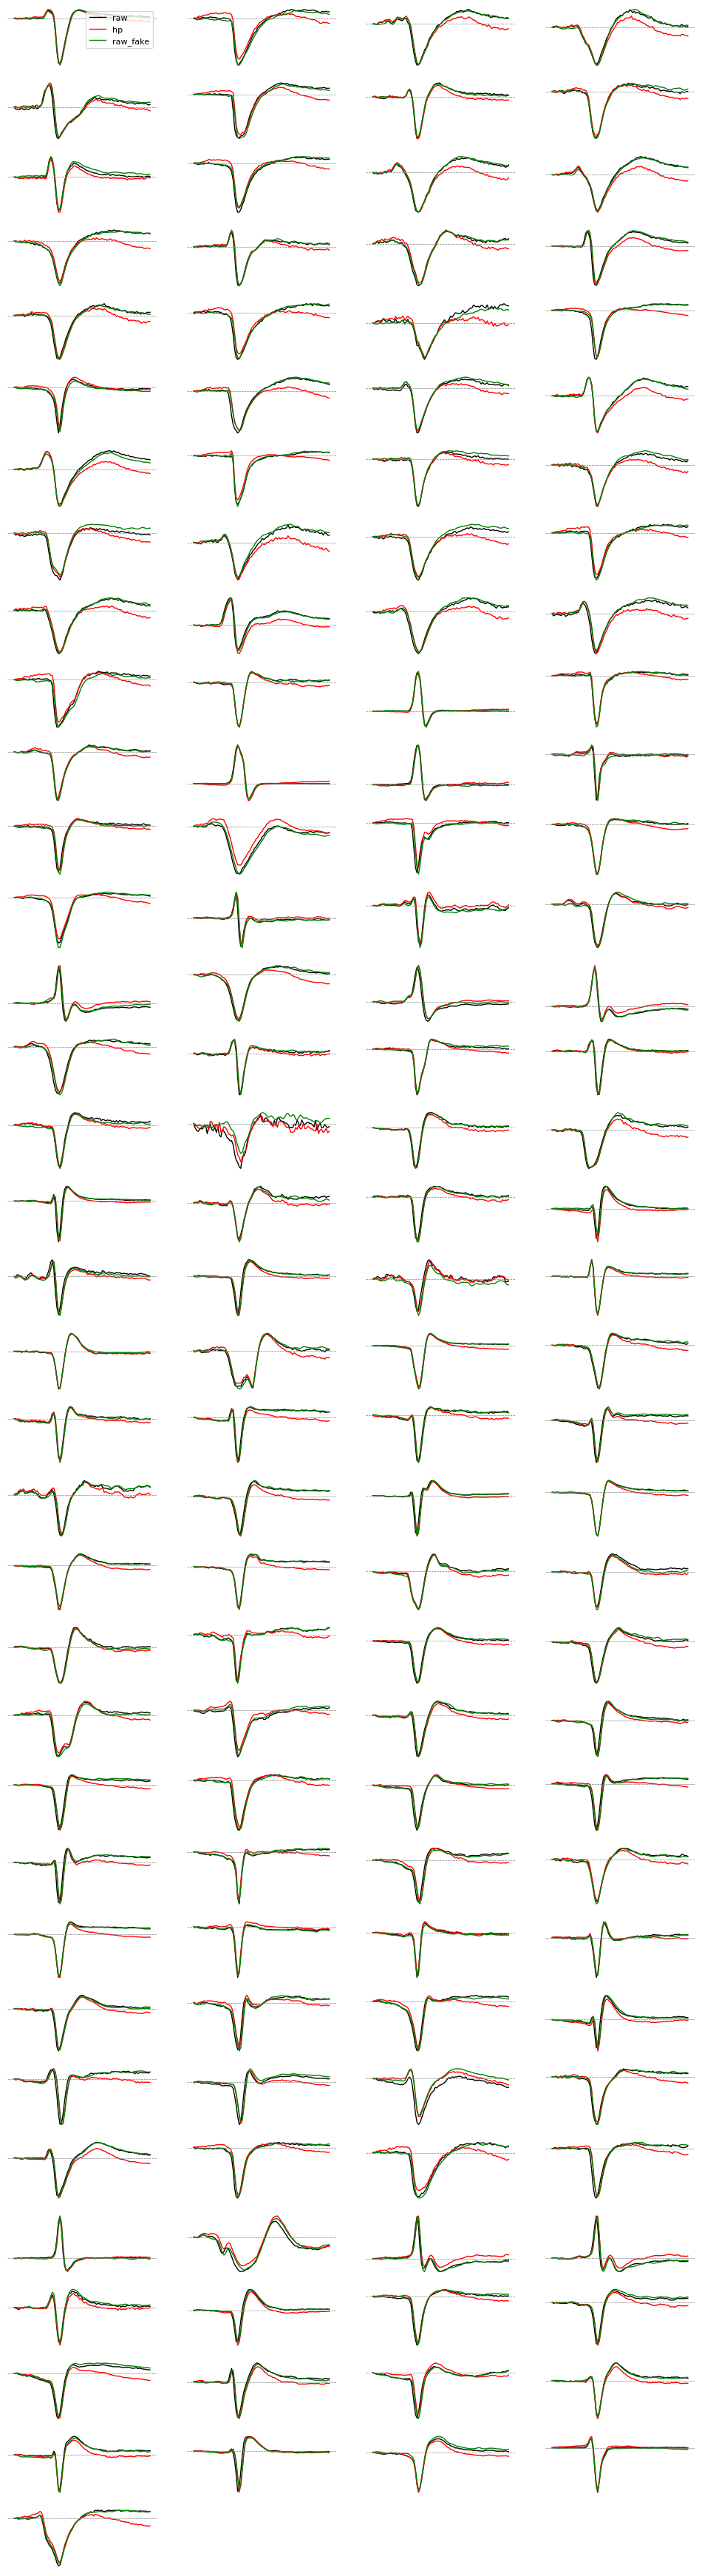

In [73]:
fig = plt.figure(figsize=(12, 45))
gs_waveforms = gs(nrows=int(np.ceil(len(unit_ids_selected)/4)), ncols=4)
for unit_id in unit_ids_selected:
    # channel
    extreme_channel_indices = si.get_template_extremum_channel(analyzer_raw, mode = "at_index", outputs = "index")
    extreme_channels = si.get_template_extremum_channel(analyzer_raw) 
    # raw
    template_ext_raw = analyzer_raw.get_extension("templates")
    unit_template_raw = template_ext_raw.get_unit_template(unit_id)       
    peak_waveform_raw = unit_template_raw[:,extreme_channel_indices[unit_id]]
    # raw_fake
    template_ext_raw_fake = analyzer_raw_fake.get_extension("templates")
    unit_template_raw_fake = template_ext_raw_fake.get_unit_template(unit_id)       
    peak_waveform_raw_fake = unit_template_raw_fake[:,extreme_channel_indices[unit_id]]    
    # hp
    template_ext_hp = analyzer_hp.get_extension("templates")
    unit_template_hp = template_ext_hp.get_unit_template(unit_id)
    peak_waveform_hp = unit_template_hp[:,extreme_channel_indices[unit_id]]
    # hp_1
    # template_ext_hp_1 = analyzer_hp_1.get_extension("templates")
    # # unit_template_hp_1 = template_ext_hp_1.get_unit_template(unit_id)
    # # peak_waveform_hp_1 = unit_template_hp_1[:,extreme_channel_indices[unit_id]]
    # # # bp
    # template_ext_bp = analyzer_bp.get_extension("templates")
    # unit_template_bp = template_ext_bp.get_unit_template(unit_id)
    # peak_waveform_bp = unit_template_bp[:,extreme_channel_indices[unit_id]]

    ax = fig.add_subplot(gs_waveforms[unit_ids_selected.tolist().index(unit_id)//4, unit_ids_selected.tolist().index(unit_id)%4])
    ax.plot(peak_waveform_raw-peak_waveform_raw[0], color='black', alpha=1, linewidth=1, label='raw')
    ax.plot(peak_waveform_hp-peak_waveform_hp[0], color='red', alpha=1, linewidth=1, label='hp')
    # ax.plot(peak_waveform_bp - peak_waveform_bp[0], color='blue', alpha=1, linewidth=1, label='bp')
    # ax.plot(peak_waveform_hp_1 - peak_waveform_hp_1[0], color='orange', alpha=1, linewidth=1, label='hp_1')
    ax.plot(peak_waveform_raw_fake-peak_waveform_raw_fake[0], color='g', alpha=1, linewidth=1, label='raw_fake')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    if unit_ids_selected.tolist().index(unit_id) == 0:
        ax.legend(loc='upper right', fontsize=8)
    # remove all boxes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # remove all ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])




In [49]:
orders = range(5)
template_exts = []
analyzers = []
# load analyzers of different orders
for order_ind, order in enumerate(orders):
    file_path = os.path.join(session_dir[f'ephys_dir_{data_type}'], f'bp_{order+1}.zarr')
    curr_analyzer = si.load(file_path, load_extensions=False)
    template_exts.append(curr_analyzer.get_extension("templates"))
    analyzers.append(curr_analyzer)

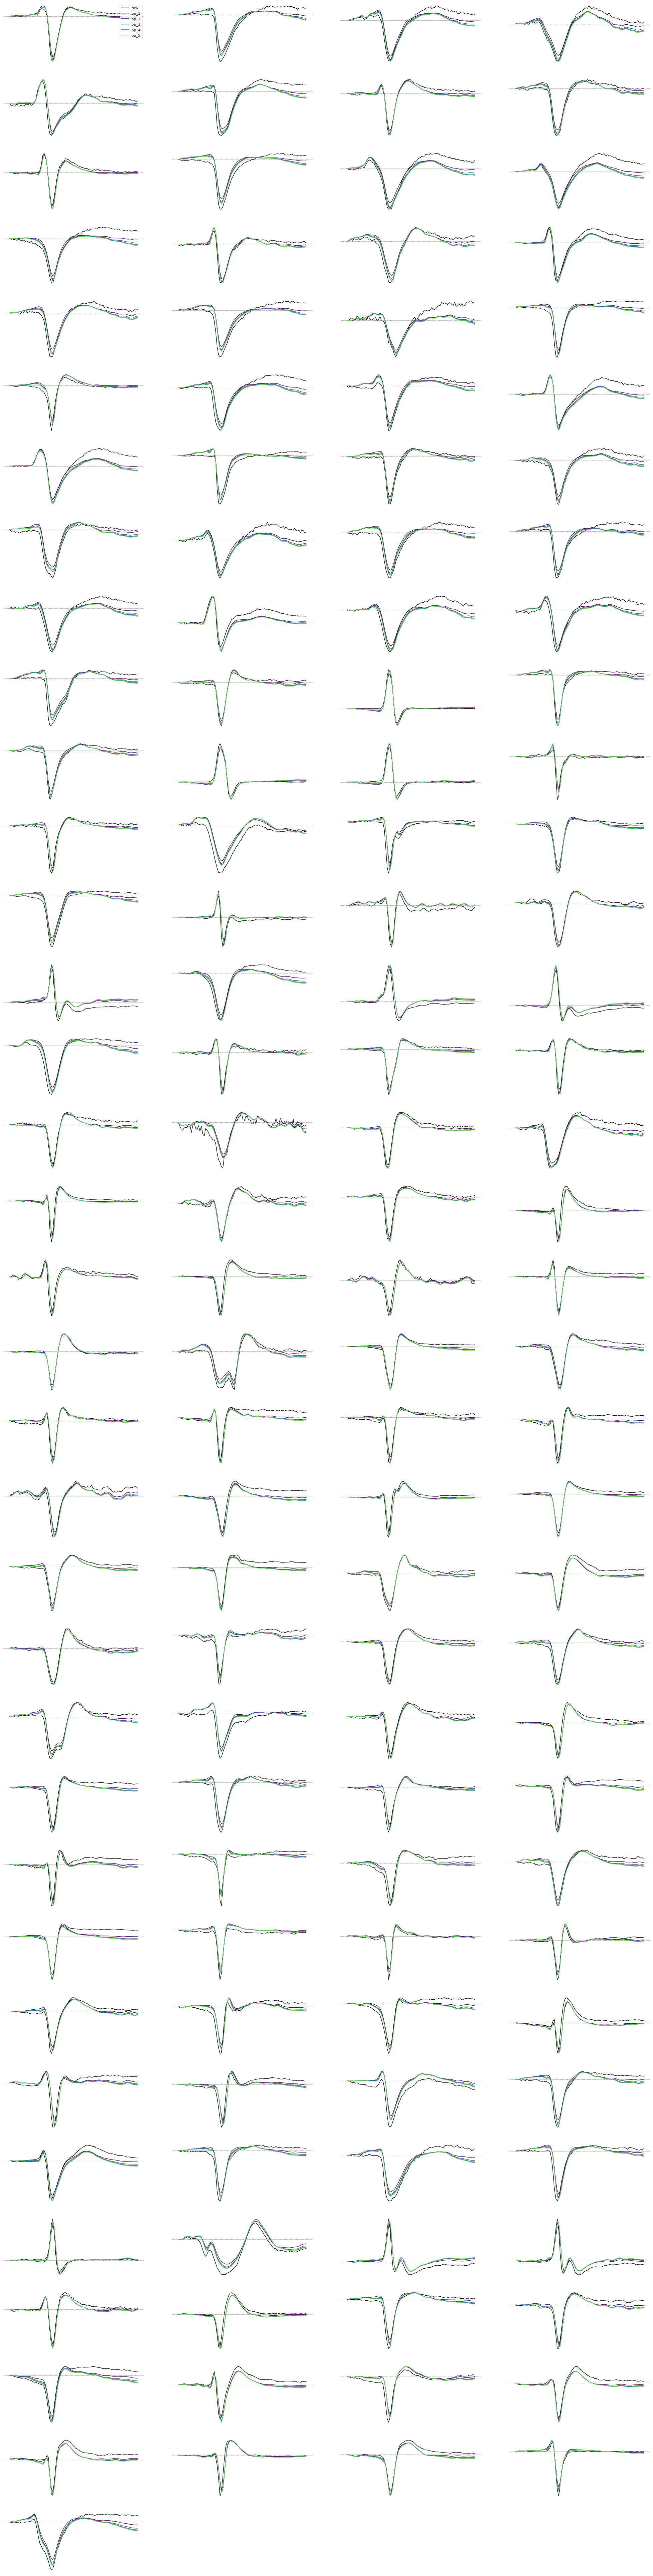

In [51]:
fig = plt.figure(figsize=(25, 100))
unit_tbl = get_unit_tbl(session, data_type, summary=True)
unit_ids_selected = unit_tbl[unit_tbl['default_qc']]['unit_id'].values
gs_waveforms = gs(nrows=int(np.ceil(len(unit_ids_selected)/4)), ncols=4)
orders = range(5)
extreme_channel_indices = si.get_template_extremum_channel(analyzer_raw, mode = "at_index", outputs = "index")
for unit_id in unit_ids_selected:
    # channel
    # raw
    template_ext_raw = analyzer_raw.get_extension("templates")
    unit_template_raw = template_ext_raw.get_unit_template(unit_id)       
    peak_waveform_raw = unit_template_raw[:,extreme_channel_indices[unit_id]]
   
    ax = fig.add_subplot(gs_waveforms[unit_ids_selected.tolist().index(unit_id)//4, unit_ids_selected.tolist().index(unit_id)%4])
    ax.plot(peak_waveform_raw - peak_waveform_raw[0], color='black', alpha=1, linewidth=1, label='raw')

    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)

    for ind, order in enumerate(orders):
        # load templates
        unit_template = template_exts[ind].get_unit_template(unit_id)
        peak_waveform = unit_template[:,extreme_channel_indices[unit_id]]
        ax.plot(peak_waveform - peak_waveform[0], 
                color=plt.cm.viridis(ind/len(orders)), 
                alpha=1, 
                linewidth=1, 
                label=f'bp_{order+1}')

    
    if unit_ids_selected.tolist().index(unit_id) == 0:
        ax.legend(loc='upper right', fontsize=8)
    # remove all boxes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # remove all ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])